In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\joris\\Documents\\eScience_data\\data'
sys.path.insert(0, ROOT)
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

## Loading data ready for training
-Creation of this data can be seen in 3b

In [2]:
# training set
outfile = os.path.join(path_data, 'nn_prep_training_found_matches_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_training_found_matches_s2v_2dec = pickle.load(inf)
else:
    nn_prep_training_found_matches_s2v_2dec = find_info_matches(old_and_unique_found_matches_s2v_2dec_top20,
                                                                old_and_unique_documents_library_s2v_2dec,
                                                                old_and_unique_documents_query_s2v_2dec,
                                                                max_parent_mass=max_parent_mass)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_training_found_matches_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_training_found_matches_s2v_2dec.pickle


In [3]:
outfile = os.path.join(path_data, 'nn_prep_testing_found_matches_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_testing_found_matches_s2v_2dec = pickle.load(inf)
else:
    nn_prep_testing_found_matches_s2v_2dec = find_info_matches(new_and_unique2_found_matches_s2v_2dec_top20,
                                                                new_and_unique2_documents_library_s2v_2dec,
                                                                new_and_unique2_documents_query_s2v_2dec,
                                                                max_parent_mass=max_parent_mass)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_testing_found_matches_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_testing_found_matches_s2v_2dec.pickle


In [4]:
nn_prep_testing_found_matches_s2v_2dec[2].iloc[:5]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim
22101,0.928457,0.663299,0.928457,0.663299,0.909346,1,1.000000,0.034743,0.999777
20538,0.856661,0.549896,0.856661,0.549896,0.859138,1,1.000000,0.034743,1.000000
22454,0.857507,0.549896,0.857507,0.549896,0.674490,1,1.000000,0.034743,1.000000
1366,0.389183,0.549896,0.389183,0.549896,0.584506,1,1.000000,0.034744,0.999554
5998,0.336160,0.070000,0.337487,0.195643,0.303197,0,0.581808,0.037051,0.000997


## Add matches together for each query

In [5]:
# add all the found matches together in one big df
nn_training_found_matches_s2v_2dec = nn_prep_training_found_matches_s2v_2dec[0].append(
    nn_prep_training_found_matches_s2v_2dec[1:])

nn_testing_found_matches_s2v_2dec = nn_prep_testing_found_matches_s2v_2dec[0].append(
    nn_prep_testing_found_matches_s2v_2dec[1:])

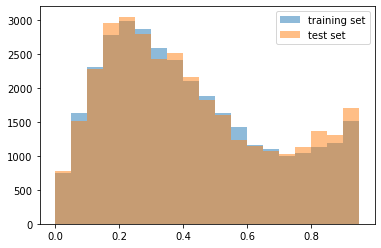

In [6]:
plt.hist(nn_training_found_matches_s2v_2dec['similarity'],
         alpha=0.5, bins = np.arange(0,1,0.05), label = 'training set')
plt.hist(nn_testing_found_matches_s2v_2dec['similarity'],
         alpha=0.5, bins = np.arange(0,1,0.05), label = 'test set')
plt.legend()
plt.show()

In [7]:
X_train = nn_training_found_matches_s2v_2dec.drop(['similarity', 'label'], axis = 1)
y_train = nn_training_found_matches_s2v_2dec['similarity']
X_test = nn_testing_found_matches_s2v_2dec.drop(['similarity', 'label'], axis = 1)
y_test = nn_testing_found_matches_s2v_2dec['similarity']

## Load model from notebook 3

In [8]:
#nn function
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

def train_nn(X_train, y_train, X_test, y_test, layers = [12, 12, 12, 12, 12, 1],
             model_loss = 'binary_crossentropy', activations = 'relu',
             last_activation = 'sigmoid', model_epochs = 20, model_batch_size = 16,
             save_name = False):
    '''Train a keras deep NN and test on test data, returns (model, history, accuracy, loss)
    
    X_train: matrix like object like pd.DataFrame, training set
    y_train: list like object like np.array, training labels
    X_test: matrix like object like pd.DataFrame, test set
    y_test: list like object like np.array, test labels
    layers: list of ints, the number of layers is the len of this list while the elements
        are the amount of neurons per layer, default: [12, 12, 12, 12, 12, 1]
    model_loss: str, loss function, default: binary_crossentropy
    activations: str, the activation of the layers except the last one, default: relu
    last_activation: str, activation of last layer, default: sigmoid
    model_epochs: int, number of epochs, default: 20
    model_batch_size: int, batch size for updating the model, default: 16
    save_name: str, location for saving model, optional, default: False
    
    Returns:
    model: keras sequential
    history: dict, training statistics
    accuracy: float, accuracy on test set
    loss, float, loss on test set
    
    If save_name is not False and save_name exists this function will load existing model
    '''
    if os.path.exists(save_name) and save_name:
        print('\nLoading existing model')
        nn_model = load_model(save_name)
        with open(save_name + '_train_hist.pickle', 'rb') as hist_inf:
            history = pickle.load(hist_inf)
    else:
        # define the keras model
        nn_model = Sequential()
        #add first layer
        nn_model.add(Dense(layers[0], input_dim = X_train.shape[1], activation = activations))
        #add other layers
        for i in range(1,len(layers)-1): #skip first and last one
            nn_model.add(Dense(layers[i], activation = activations))
        #add last layer
        nn_model.add(Dense(layers[-1], activation = last_activation))
        # compile the keras model
        nn_model.compile(loss = model_loss, optimizer='adam', metrics=['accuracy'])
        # fit the keras model on the dataset
        hist = nn_model.fit(X_train, y_train, epochs = model_epochs, batch_size = model_batch_size)
        history = hist.history
    
    #training set
    print('Training loss: {:.4f}\n'.format(history['loss'][-1]))
    
    #test set    
    loss, accuracy = nn_model.evaluate(X_test, y_test)
    print('Test accuracy: {:.2f}'.format(accuracy*100))
    print('Test loss: {:.4f}'.format(loss))
    
    if save_name and not os.path.exists(save_name):
        print('Saving model at:', save_name)
        nn_model.save(save_name)
        with open(save_name + '_train_hist.pickle', 'wb') as hist_outf:
            pickle.dump(history, hist_outf)
    
    return nn_model, history, accuracy, loss

In [ ]:
test_layers = [10,24,1]
#model_name = os.path.join(path_data, 'nn_2000_queries_top20_1')
model_name = os.path.join(path_data, 'nn_2000_queries_top20_layers_opt_1') #this one tested best in notebook 3

X_tanimoto_top20 = nn_training_found_matches_s2v_2dec.drop(['similarity', 'label'], axis = 1)
y_tanimoto_top20 = nn_training_found_matches_s2v_2dec['similarity']
X_tanimoto_top20_test = nn_testing_found_matches_s2v_2dec.drop(['similarity', 'label'], axis = 1)
y_tanimoto_top20_test = nn_testing_found_matches_s2v_2dec['similarity']

nn_2000_queries_top20_1 = train_nn(X_tanimoto_top20, y_tanimoto_top20, X_tanimoto_top20_test, y_tanimoto_top20_test, layers = test_layers,
         model_loss = 'mean_squared_error', activations = 'relu', last_activation = None,
         model_epochs = 50, model_batch_size = 16, save_name = model_name)